This notebook is an EDA Exploratorie Data Analysis for the "UW-Madison GI Tract Image Segmentation" competition. 

## Introduction

Before exploring the data, we need to understand the context of this competition, and the different notions we are going to analyze. This will allow us to have a better understanding of the problem, the data and about the solution that we are going to propose.

The main idea of this competition is to track healthy organs in medical scans to improve cancer treatment. New technology as integrated magnetic resonance imaging and linear accelerator systems, also known as MR-Linacs, allowing oncologists to visualize the daily position of the tumor and intestines from a patient on a daily basis. Indeed, the tumor position can vary day to day.

From the medical scan, radiation oncologists must manually outline the position of the stomach and intestines in order to adjust the direction of the x-ray beams to increase the dose delivery to the tumor and to avoid the stomach and intestines. This annotation process is time-consuming and labor-intensive, which can prolong treatments from 15 minutes a day to an hour a day, which can be difficult for patients to tolerate. 

A solution could be to use deep learning, in order to help the segmentation process. A method to segment the stomach and intestines would make treatments much faster and would allow more patients to get more effective treatment.

## MR-Linec

The MR-Linac machine combines two technologies — an MRI scanner and a linear accelerator — to precisely locate tumors, tailor the shape of X-ray beams in real time, and accurately deliver doses of radiation even to moving tumors. In short, it is used to precisely locate tumors and accurately deliver doses of radiation.

MRI can visualize tumour targets and surrounding organs with high accuracy, delivering the ability to “see what you treat” and, ultimately, the potential for real-time treatment adaptation based on anatomical changes observed during treatment. MR-Linac is a possible solution that can allow Online Adaptive Radiation Therapy (ART). It requires to exploit imaging signals with different quality of information and merging them in order to perform real-time processing. Moreover, MR-Linal allow to reduce the number of required hospital visits, improving both patient comfort and treatment efficiency. Also, it offers overall economic benefits and enables safer treatment. 

## Parts of the body analyzed 

In this competition, we focus our research on the segmentation of three organs : 

- [Stomach](https://en.wikipedia.org/wiki/Stomach)
- [Large bowel](https://en.wikipedia.org/wiki/Large_intestine) : also known as large intestine 
- [Small bowel](https://en.wikipedia.org/wiki/Small_intestine) : also known as small intestine 


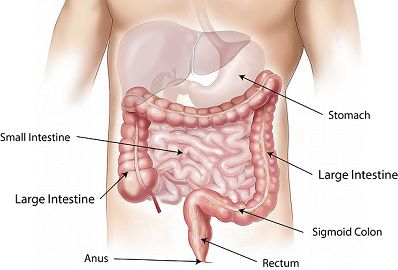

Image reference (https://coredifferences.com/difference-between-small-intestine-and-large-intestine/)


> More information : https://my.clevelandclinic.org/health/body/21758-stomach

## Segmentation task

Human could also have difficulties in annotating the area. Due to fatigue or inadvertence, some errors can surge. By using artificial intelligence to support a radiation oncologist during his process, we could imagine during the annotation process that the system could share information and help the oncologist during this task or to pre-fill the area. This steps should also be discussed with the radiation oncologists in order to understand their need during the process and thus to help them in their jobs. Indeed, we need to stay in mind that we are working with medical cases. And behind that, we have real people, real case and thus life at stake. We need to be careful with the results and the process we want to implement.

## Datasets

[In this dataset](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation), we have multiples cases from different patient. Each case is represented by multiple sets of scan slices. Moreover, we could have multiple day analysis in our dataset. Some cases are split by time (early days are in train, later days are in test) while some cases are split by case - the entirety of the case is in train or test. The goal of this competition is to be able to generalize to both partially and wholly unseen cases.

We have at our disposal images issue from MRI with a given segmentation for each image. The segmentation is defined as RLE-encoded masks. The images are in 16-bit grayscale PNG format. We know the shape of our data, but we don't know the pretreatment realized beforehand. 

## Run-Length Encoding (RLE)

RLE is a form of lossless data compression. In our case, for mask, we only have binary value. 
When we have a mask (value equals 1), we generally have a structure of succesive value that follow. Thus, instead of save all the image array, a smart way is to keep only the stating pixel of the positve value and the number of successive positive pixel we have. For example : 3 5 means that at the pixel number 3, we have 5 following 1. (00111110000)


## MRI Images

TODO ...


In [ ]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import random
import cv2

from PIL import Image
from IPython.display import IFrame

In [ ]:
# Read the data
df_train = pd.read_csv("../input/uw-madison-gi-tract-image-segmentation/train.csv")
df_train.head()

In [ ]:
print("Number of rows in our dataset :", len(df_train))
print("Number of unique data         :", len(df_train["id"].unique()))
print("Classes availables            :", df_train["class"].unique())

LABELS = df_train["class"].unique()

In our data, for each id, we have 3 associated row representating the segmentation for the 3 classes.

In [ ]:
# Decompose the field "id" in order to have the case and the day
df_train["case_id"]       = df_train.apply(lambda x : x["id"].split("_")[0], axis = 1)
df_train["day"]           = df_train.apply(lambda x : x["id"].split("_")[1], axis = 1)
df_train["slice"]         = df_train.apply(lambda x : x["id"].split("_")[3], axis = 1)
df_train["slice_id"]      = df_train["slice"].astype("int")
df_train["image_folder"]  = df_train.apply(lambda x : '_'.join(x["id"].split("_")[0:2]), axis = 1)

df_train.head()

In [ ]:
print("Number of unique case    :", len(df_train["case_id"].unique()))
print("Number of unique analyze :", len(df_train["image_folder"].unique()))

In [ ]:
nb_no_segmentation = df_train["segmentation"].isna().sum()
nb_segmentation    = len(df_train) - nb_no_segmentation

perc_segmentation     = nb_segmentation * 100 / len(df_train)
perc_no_segmentation  = nb_no_segmentation * 100 / len(df_train)

print("Number of images with a segmentation  :", nb_segmentation, " | ", "{:.2f}".format(perc_segmentation), "%")
print("Number of images with no segmentation :", nb_no_segmentation, " | ", "{:.2f}".format(perc_no_segmentation), "%")

## Impact of the slice

A question that we could ask is about the relation between the slice and the segmentation. Thus, could we have an idea based on the slice we studied of the possible segmentation ? In other word, is there a slice more segmented than another ?


First, we are going to analyze the number of images for each slice.

In [ ]:
# Divide by 3 because 3 times the images.
(df_train["slice"].value_counts(sort=False,ascending=True) / 3).plot()

As we can see from the chart above, is that we have a larger number of slices with the id 0001 to 0081. For them, we have 274 images. For the slice with the id from 0082 to 0141, we have 259 images.


Now, we are going to see, if some slice have more segmentation than others. For that, we are also going to analyse each number of slice by his label. 

In [ ]:
# We are going to count for each label the number of segmentation non null per slide.
COLORS = ["red", "blue", "green"]

plt.figure()

for i, label in enumerate(LABELS):
    df_train[df_train["class"] == label][["slice", "segmentation"]].groupby("slice")["segmentation"].count().plot(color = COLORS[i], label = label)

plt.legend()
plt.show()

With the figure above, we can see that the small bowel and the large bowel share many slices, with a peak around 110. We can see that the slice for the stomach seems to be more frequent in the earlier slice, with a peak around 61.

Next, we are going to visualize the number of segmentation per slice by using the group of label.

In [ ]:
from itertools import combinations

combinaisons = combinations(LABELS, 2)

plt.figure()

for i, combinaison in enumerate(list(combinaisons)):    
    df_train[df_train["class"].isin(combinaison)][["slice", "segmentation"]].groupby("slice")["segmentation"].count().plot(color = COLORS[i], label = combinaison)

plt.legend()
plt.show()

Finally, we are going to visualize the number of segmentation by using all the label in one group.

In [ ]:
plt.figure()
df_train.groupby("slice")["segmentation"].count().plot(label = " ".join(LABELS))
plt.legend()
plt.show()

With this analyzed, we have seen that the number of the slice have an impact of the number of segmentation we will have. Moreover, based on the slice, we could have an idea of the presence of the organ. This is something that could be use during the segmentation part, if all the study have the same normalization and if the scan was taken with the same method.

Now, we are going to analyze the pixel value of the segmentation mask.

In [ ]:
# TODO :: Need to check, think we got an error.
plt.figure()

for i, label in enumerate(LABELS) :
    # Compute the number of pixels per slice
    df_label_segmentation = df_train[(df_train["class"] == label) & ~(df_train["segmentation"].isna())]
    df_label_segmentation.groupby("slice")["segmentation"].apply(lambda x : sum(list(map(int, str(x.values[0]).split(" ")[1::2]))) ).plot(color = COLORS[i], label = label) 

plt.legend()
plt.show()

Another approach could be to multiply the number of segmentation per the number of pixel present in the mask. Thus, we will see the impact of the mask. Indeed, we could have mask with only one pixel and other more important with a larger number.

In [ ]:
plt.figure()

for i, label in enumerate(LABELS) :
    # Compute the number of pixels per slice
    df_label_segmentation = df_train[(df_train["class"] == label) & ~(df_train["segmentation"].isna())]
    
    slice_segmentation_count = df_label_segmentation.groupby('slice')["segmentation"].count().values
    
    (df_label_segmentation.groupby("slice")["segmentation"].apply(lambda x : sum(list(map(int, str(x.values[0]).split(" ")[1::2]))) ) * slice_segmentation_count).plot(color = COLORS[i], label = label)
    
plt.legend()
plt.show()

As we can see with the figure above is the 



It is interesting to notice, that in the previous figure, we saw that the larger bowel have a large amount of segmented images at the slices around 120. But here, with this representation, we see that we finaly we have low amount of pixel in those mask.


It' also interesting to notice that the stomach segmentation seems to be sharp. We could see peaks on the green line in our figure. 
Thus, it could ba interesting to see how the segmentation have been realized for this organs.




## Get image metadata

The image filenames also contains information. Indeed the filenames include 4 numbers (ex. 276_276_1.63_1.63.png). These four numbers are slice height / width (integers in pixels) and heigh / width pixel spacing (floating points in mm). The first two defines the resolution of the slide. The last two record the physical size of each pixel.

In [ ]:
INPUT_FOLDER = "../input/uw-madison-gi-tract-image-segmentation/train/"
path_images = INPUT_FOLDER + df_train["case_id"] + "/" + df_train["image_folder"] + "/scans/slice_" + df_train["slice"] + "*.png"

In [ ]:
heights, widths, heights_spacing, widths_spacing, filenames = [], [], [], [], []

for path in path_images:
    
    files = glob.glob(path)
    
    filename = files[0].split('/')[-1]
    element  = filename.split('_')

    filenames.append(files[0])
    heights.append(element[-4])
    widths.append(element[-3])
    heights_spacing.append(element[-2])
    widths_spacing.append(element[-1][0:-4])

df_metadata = pd.DataFrame({
    'path': filenames,
    'heigth': heights,
    'width': widths,
    'heigth_spacing': heights_spacing,
    'width_spacing': widths_spacing,
})
    
df_metadata.head()

In [ ]:
# Merge the two dataframe
df_train = df_train.join(df_metadata)
df_train.head()

In [ ]:
df_train["heigth"].unique()

In [ ]:
df_train["width"].unique()

In [ ]:
square_data     = df_train[(df_train["width"] == df_train["heigth"])]
not_square_data = df_train[~(df_train["width"] == df_train["heigth"])]

# Compute the number of data
len_square_data     = int(len(square_data) / 3)
len_not_square_data = int(len(not_square_data) / 3)
len_total_images    = len_square_data + len_not_square_data

perc_square_data     = len_square_data / len_total_images
perc_not_sqaure_data = len_not_square_data / len_total_images

print("Number of square images     : ", len_square_data, " - Percentage : ", "{:.2f}".format(perc_square_data), "%")
print("Number of not square images : ", len_not_square_data, " - Percentage : ", "{:.2f}".format(perc_not_sqaure_data), "%")

In [ ]:
# See the possible combinaison for the image size
possible = df_train[["width", "heigth"]].values

unique_data = [x for x in set(tuple(x) for x in possible)]
print("Possible resolution of the images :")
print(unique_data)
print()

resolutions = [tuple(x) for x in possible]

for resolution in unique_data:
    
    resolution_count  = resolutions.count(tuple(resolution))
    resolution_number = int(resolution_count / 3)
    resolution_pourcentage = resolution_number / (int(len(df_train) / 3))
    
    print("Resolution :", tuple(resolution), " - Number :", "{:>5}".format(resolution_number), " - Percentage :", "{:.3f}".format(resolution_pourcentage), "%")

First, we can see that we have two resolutions with low distribution : (234, 234) and (276, 276).
We can see that the resolution (266, 266) has the highest distribution, with more than 60 % of the data.
Then, we see that the (310, 360) represents about 30% of our data.

We are going to see which data represent the few resolution.

In [ ]:
df_train[(df_train["width"] == "234") & (df_train["heigth"] == "234")].case_id.unique()

In [ ]:
df_train[(df_train["width"] == "276") & (df_train["heigth"] == "276")].case_id.unique()

## Analyze the spacing

In [ ]:
spacing_data = df_train[["width_spacing", "heigth_spacing"]].values
spacing_data = [tuple(x) for x in spacing_data]

spacing_unique = [list(x) for x in set(spacing_data)]
print(spacing_unique)

In [ ]:
for spacing in spacing_unique:
    print("Resolution :", tuple(spacing), " - Number :", int(spacing_data.count(tuple(spacing)) / 3))

In [ ]:
df_train[(df_train["width_spacing"] == "1.63") & (df_train["heigth_spacing"] == "1.63")].case_id.unique()

It is interesting to notice that the image with a resolution of (276, 276) have the same spacing of 1.63.

## Visualize the segmentation

In [ ]:
import math 

def rle_decode(mask_rle, shape):
    '''
    Create an array of dimension 1. Fill the array with 1 when corresponding the mask. 
    Finally reshape our array to the image dimension.
    
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    if isinstance(mask_rle, float) and math.isnan(mask_rle):
        return np.zeros(shape[0] * shape[1], dtype=np.uint8).reshape(shape)
    
    if mask_rle != mask_rle:
        return np.zeros(shape[0] * shape[1], dtype=np.uint8).reshape(shape)
    
    
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def view_images(images, nb_elements = 5):
    nb_samples = len(images)
    
    nb_rows = ((nb_samples) // 5) + 1
    
    fig, axes = plt.subplots(
        nrows = nb_rows, 
        ncols = min(5, nb_samples), 
        figsize = (min(5, nb_samples) * 4, nb_rows * 4)
    )
    
    for i in range(nb_samples):    
        img = images[i]
        axes[i // 5, i % 5].imshow(np.array(img), cmap=plt.cm.gray, aspect='auto')
        axes[i // 5, i % 5].axis('off')
    
    fig.show()    

In [ ]:
def select_random_study(df_data):
    # Select a random case_id
    data_case_id         = df_data["case_id"].unique()
    case_id              = random.choice(data_case_id)
    case_analyze         = df_data[df_data["case_id"] == case_id]
    
    # Select a random day 
    day_selected         = random.choice(case_analyze.day.unique())
    day_analyze          = case_analyze[case_analyze["day"] == day_selected] 
    
    return day_analyze

# Select the data with a segmentation
segmentation_data = df_train[~df_train["segmentation"].isna()]

random.seed(0)

day_analyzed  = select_random_study(df_train)

### Visualization simple mask

For visualizing a mask, we can have mulitple approach. The first one is to only viusalize the mask. Then, a second possible approch is to visualize the mask with the input image.

In [ ]:
stomach_analyzed          = day_analyzed[day_analyzed["class"] == "stomach"].sort_values("slice")
larger_bowel_analyzed     = day_analyzed[day_analyzed["class"] == "large_bowel"].sort_values("slice")
small_bowel_analyzed      = day_analyzed[day_analyzed["class"] == "small_bowel"].sort_values("slice")

In [ ]:
def make_gif(frames, filename="my_gif"):
    frame_one = frames[0]
    frame_one.save(f'/kaggle/working/{filename}.gif', format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)
    return frame_one

def get_mask(df):
    mask_array = []

    for index, row in df.iterrows():    

        mask = rle_decode(row["segmentation"], (int(row["width"]), int(row["heigth"])))
        mask_array.append(mask)

    mask_images = [Image.fromarray(mask * 255) for mask in mask_array]
    return mask_images

def open_medical_image(image_path, normalize=True):
    img = cv2.imread(image_path, cv2.CV_16UC1)
    if normalize:
        img = ((img / img.max()) * 255).astype(np.uint8)
    img = Image.fromarray(img)
    return img

In [ ]:
seg_stomach_analyzed = stomach_analyzed[~stomach_analyzed["segmentation"].isna()]
mask_images = get_mask(seg_stomach_analyzed)

In [ ]:
view_images(mask_images)

Visualize the mask as an animation

In [ ]:
mask = make_gif(mask_images)

IFrame("./my_gif.gif", width=360, height=310)

In [ ]:
seg_stomach_analyzed      = stomach_analyzed[~stomach_analyzed["segmentation"].isna()]
seg_larger_bowel_analyzed = larger_bowel_analyzed[~larger_bowel_analyzed["segmentation"].isna()]
seg_small_bowel_analyzed  = small_bowel_analyzed[~small_bowel_analyzed["segmentation"].isna()]

seg_stomach = get_mask(seg_stomach_analyzed)
seg_larger  = get_mask(seg_larger_bowel_analyzed)
seg_small   = get_mask(seg_small_bowel_analyzed)

In [ ]:
from ipywidgets import Output, GridspecLayout
from IPython import display


def visualize_all_mask(df):
    # Get the corresponding class 
    stomach          = df[df["class"] == "stomach"].sort_values("slice")
    larger_bowel     = df[df["class"] == "large_bowel"].sort_values("slice")
    small_bowel      = df[df["class"] == "small_bowel"].sort_values("slice")
    
    # Get the mask 
    seg_stomach = get_mask(stomach)
    seg_larger  = get_mask(larger_bowel)
    seg_small   = get_mask(small_bowel)
    
    # Show the mask with GIF 
    grid = GridspecLayout(1, 3)
    
    make_gif(seg_stomach, "stomach")
    make_gif(seg_larger, "larger")
    make_gif(seg_small, "small")

    for i, name in enumerate(["stomach", "larger", "small"]):
        out = Output()
        with out:
            display.display(IFrame(f'./{name}.gif', width=360, height=360))
        grid[0, i] = out
    
    return grid

Now, we are going to visualize the three masks according his class.

In [ ]:
visualize_all_mask(day_analyzed)

We are now going to visualize an image with the mask. This will allow us to visualize the area.

In [ ]:
def create_heatmap_and_extract_images(df):
    
    images, masks = [], []
    slice_max = df["slice_id"].max()
    
    # For each slice
    for slice_idx in range(1, slice_max):
    
        # Get the slice 
        rows = df[df['slice_id'] == slice_idx]
        data = rows.iloc[0]
    
        # Open the classic image
        image = open_medical_image(data["path"])
        
        # Get the row from the class
        stomach      = rows[rows["class"] == "stomach"]
        larger_bowel = rows[rows["class"] == "large_bowel"]
        small_bowel  = rows[rows["class"] == "small_bowel"]
        
        # Get the mask 
        seg_stomach = np.asarray(get_mask(stomach)[0])
        seg_larger  = np.asarray(get_mask(larger_bowel)[0])
        seg_small   = np.asarray(get_mask(small_bowel)[0])

        # Create a mask grouping the information 
        seg_stomach = (seg_stomach // 255)
        seg_larger  = (seg_larger // 255) * 2
        seg_small   = (seg_small // 255) * 3
        
        mask = seg_stomach + seg_larger + seg_small
        mask = np.asarray(mask, int)
        
        images.append(image)
        masks.append(mask)
        
    return images, masks
    
def visualize_images_and_mask_as_gif(images, masks):
    image_with_mask = []
    for i in range(len(images)):

        image = images[i]
        mask  = masks[i]

        # Transform our grayscale image in color
        color = np.asarray(image.convert('RGB'))
        
        # Create a mask with color pixel
        color_mask = np.zeros_like(mask)
        color_mask = np.array(Image.fromarray(color_mask.astype(np.uint8)).convert('RGB'))
        color_mask[mask == 1] = (255,255,0)
        color_mask[mask == 2] = (0,255,255)
        color_mask[mask == 3] = (255,0,255)

        # Supperpose the image and the mask
        super_imposed_img = cv2.addWeighted(np.asarray(color), 0.99, np.asarray(color_mask), 0.50, 0)
        super_imposed_img = Image.fromarray(super_imposed_img)

        image_with_mask.append(super_imposed_img)

    # Create a gif and visualize it
    make_gif(image_with_mask, "image_with_mask")
    display.display(IFrame(f'./image_with_mask.gif', width=360, height=360))
    
    
images, masks = create_heatmap_and_extract_images(day_analyzed)
visualize_images_and_mask_as_gif(images, masks)

In [ ]:

def read_scan_images(folder):
    images = []
    images_path = glob.glob(folder + "*.png")
    for imgage_path in images_path:
        
        image = open_medical_image(imgage_path, normalize=False)
        images.append(image)
        # images.append((np.array(Image.open(imgage_path)).astype("uint16")))
    return images

def read_scan_images_from_df(df):
    images = []
    for index, row in df.iterrows():
        url = INPUT_FOLDER + "{0}/{1}/scans/slice_{2}_*.png".format(row["case_id"], row["image_folder"], row["slice"])
        
        image_path = glob.glob(url)[0]

        image = open_medical_image(image_path, normalize=True)
        images.append(image)
    return images

def get_images_from_id(folder: str, id_case: str):
    elements = id_case.split('_')
    case_id = elements[0]
    day_id = case_id + "_" + elements[1]
    
    return glob.glob(folder + "/" + str(case_id) + "/" + day_id + "/scans/*.png")
    
images = read_scan_images("../input/uw-madison-gi-tract-image-segmentation/train/case101/case101_day20/scans/")
images_id = get_images_from_id("../input/uw-madison-gi-tract-image-segmentation/train", "case123_day20_slice_0001")

In [ ]:
image = np.asarray(images[50])

In [ ]:
image.max()

In [ ]:
plt.hist(image.flatten(), bins=25)
plt.show()

In [ ]:
m_image = image.copy()
m_image[image < 50] = 0
m_image[image > 200] = 0

Image.fromarray(((m_image / m_image.max()) * 255).astype(np.uint8))

## Image enhancement

By using histogram equalization, we can have a different vision of the image.

In [ ]:
import cv2

img = cv2.imread("../input/uw-madison-gi-tract-image-segmentation/train/case101/case101_day20/scans/slice_0025_266_266_1.50_1.50.png", cv2.CV_16UC1)
img = ((img / img.max()) * 255).astype(np.uint8)
img = Image.fromarray(img)
img

In [ ]:
equ = cv2.equalizeHist(np.array(img))
plt.hist(equ.flatten(), bins=25)
plt.show()

In [ ]:
Image.fromarray(equ)

## Other plan visualization 

In computer vision, we used to see image as 2D representation. However, for MRI images, we have 3 axes representing the 3D model. The 3 axes are called : 

- Saggital plane
- Coronal plane
- Transverse plane

We can visualize them with the schema bellow.

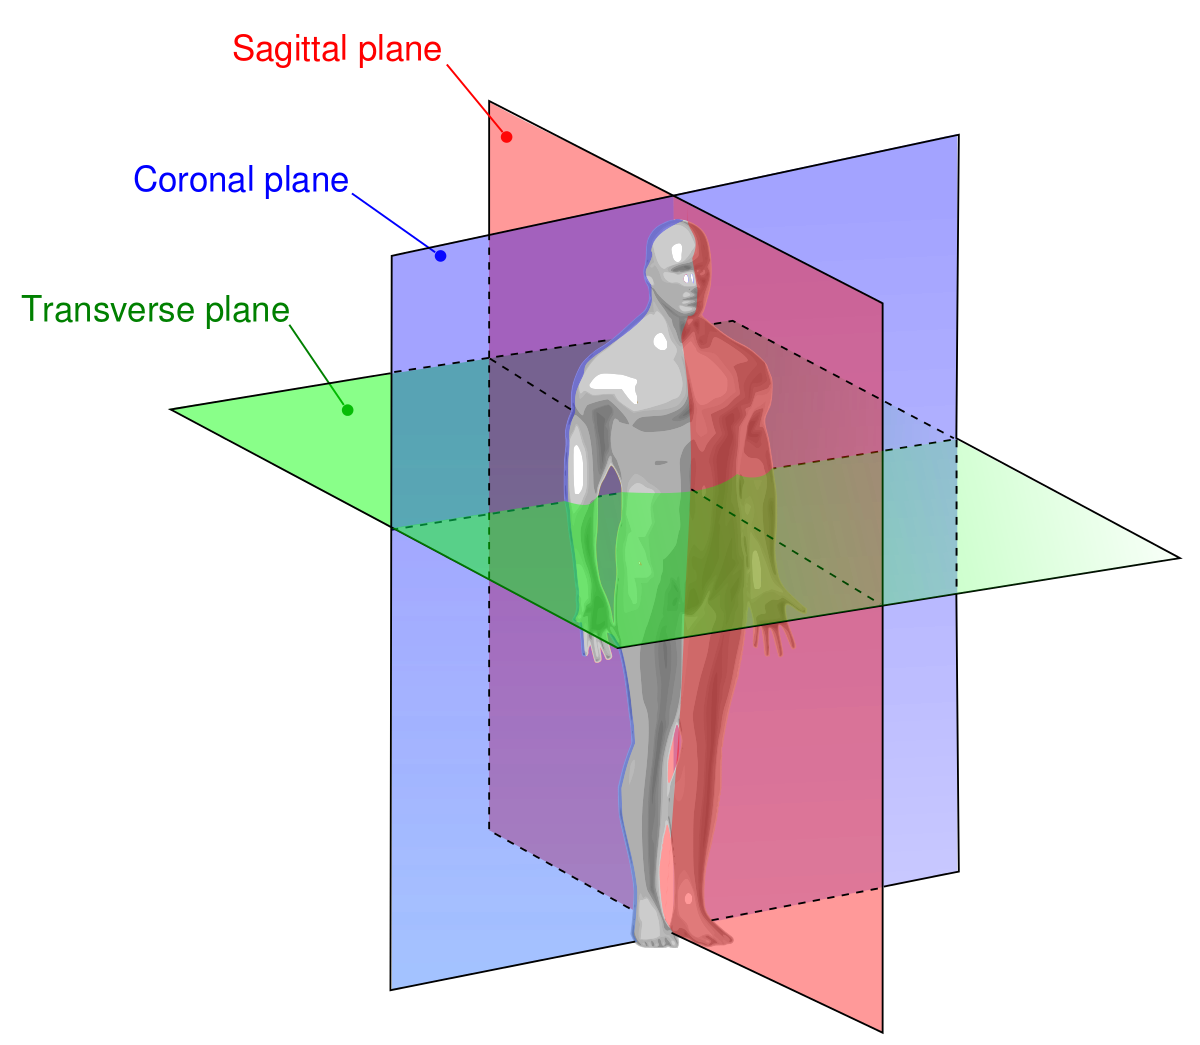


In the following code, we are going to visualize other plan representation.

In [ ]:
# Get random sample
random_data = df_train.sample(1, random_state = 0)

# Get the corresponding case 
case_id      = random_data["case_id"].values[0]
image_folder = random_data["image_folder"].values[0]
samples = df_train[df_train["image_folder"] == image_folder].sort_values("slice")

# Get and show the image
images = read_scan_images_from_df(samples)
make_gif(images)
IFrame("./my_gif.gif", width=360, height=310)

In [ ]:
# Visualize other plan 
study_case_images = np.array([np.asarray(img) for img in images])

s, c, t = study_case_images.shape

print(study_case_images.shape)

In [ ]:
size = (s*2, t*2)

left_dim_images = []
for i in range(study_case_images.shape[1]):
    img = Image.fromarray(study_case_images[:, i, :])
    img = img.resize(size) 
    left_dim_images.append(img)

make_gif(left_dim_images)

IFrame("./my_gif.gif", width=size[0], height=size[1])

In [ ]:
size = (s * 2, c * 2)

left_dim_images = []
for i in range(study_case_images.shape[1]):
    img = Image.fromarray(study_case_images[:, :, i])
    img = img.resize(size) 
    left_dim_images.append(img)

make_gif(left_dim_images)

IFrame("./my_gif.gif", width=size[0], height=size[1])

TODO :: Vizualize more data !

TODO :: Interview of a doctor / How do they see the concern area ?


Note :
- Research on how center the images ? Crop the interested area ?
